In [1]:
import warnings
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
import pandas as pd
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 2000
plt.style.use('seaborn-whitegrid')

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd 
twitter_dataset = pd.read_csv("gdrive/My Drive/twitter_dataset.csv", sep=',')

In [4]:
replaces = {"Sentiment":  {"negative": 1, "neutral": 2, "positive" : 3}}
twitter_dataset = twitter_dataset.replace(replaces)
twitter_dataset['Release date']  = pd.to_datetime(pd.to_datetime(twitter_dataset['Release date']).dt.date)
twitter_dataset.dtypes

Unnamed: 0               int64
Ticker                  object
Data source             object
Headline                object
Content                 object
Release date    datetime64[ns]
Sentiment                int64
Topic                   object
dtype: object

In [5]:
twitter_dataset.head(5)

,Unnamed: 0,Ticker,Data source,Headline,Content,Release date,Sentiment,Topic
0,0,Netflix,Twitter,#Ratched going to be on #Netflix tomorrow,No content,2020-09-17,2,Twitter news
1,1,Netflix,Twitter,RT @BadWolfAlpha_: Must See Neflix Behind The Scenes: The Umbrella Academy | Podcast | Netflix h...,No content,2020-08-05,2,Twitter news
2,2,Google,Twitter,RT @mekshaati: #Asalamo_alekom join us on ur holiday u wont regret it #chalet #break Venus #Ri...,No content,2020-08-03,3,Twitter news
3,3,Youtube,Twitter,VALORANT LIVE STREAM #23 https://t.co/8d6Ie1c8Br via @YouTube #VALORANT #ValorantClips #YouTube...,No content,2020-08-08,2,Twitter news
4,4,Youtube,Twitter,The Lounge Presents : Marcell Pierre https://t.co/M8JCIzlrEU via @YouTube #soundcloud #song #p...,No content,2020-08-09,3,Twitter news


In [6]:
twitter_dataset.Ticker.value_counts()

Youtube      118341
Twitch       118293
Netflix      116725
Apple        116457
Google       105181
Microsoft     86077
Amazon        77601
Tesla         71117
Nvidia        31316
AMD           25801
UBER           3530
Name: Ticker, dtype: int64

In [7]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install dtaidistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.4 MB/s eta 0:00:00


In [9]:
def relation_count(series):
  if 3 not in series.value_counts().index.tolist():
    pos_count = 0
  else:
    pos_count = series.value_counts()[3]
  if 2 not in series.value_counts().index.tolist():
    neutral_count = 0
  else:
    neutral_count = series.value_counts()[2]
  if series.shape[0] == 0:
    return 0
  if series.shape[0] == neutral_count:
    return 0
  return pos_count/(series.shape[0] - neutral_count)

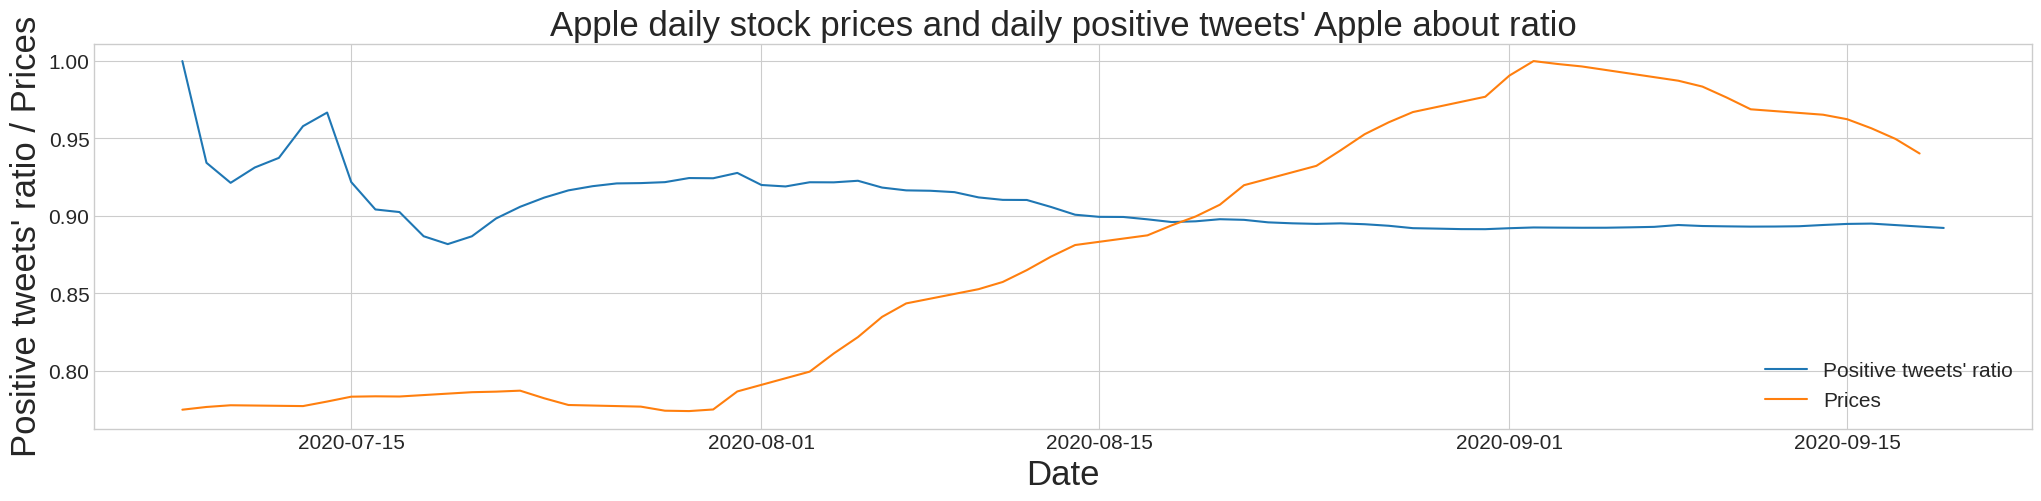

In [17]:
from matplotlib import style
from scipy.signal import savgol_filter

apple_twitter = twitter_dataset[twitter_dataset.Ticker == 'Apple']
apple_twitter.dtypes
grouped = apple_twitter.groupby('Release date', group_keys=True, sort=True)
keys = list(grouped.groups.keys())[0:]
heights = grouped.agg({'Sentiment':[relation_count]})['Sentiment']['relation_count'].ewm(com=200.5).mean()
amounts = grouped.agg({'Sentiment':['count']})['Sentiment']['count'].ewm(30).mean()
heights = np.array(heights)
amounts = np.array(amounts)

import yfinance as yahooFinance
plt.figure(figsize=(25, 5))
apple_history = yahooFinance.Ticker("AAPL")
plt.title('Daily Apple mean historical stock prices')
plt.xlabel('Date')
plt.ylabel('Historical stock prices')
history = apple_history.history(start="2020-07-08", end='2020-09-20')
history.reset_index(inplace=True)
history['Date']  = pd.to_datetime(history['Date']).dt.date
prices = history['Close'].ewm(7.5).mean()
prices = prices / np.max(prices)
heights = heights / np.max(heights)
dates = list(history['Date'])

plt.plot(keys, heights, label = 'Positive tweets\' ratio')
plt.plot(dates, prices, label = 'Prices')
plt.title('Apple daily stock prices and daily positive tweets\' Apple about ratio', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Positive tweets\' ratio / Prices', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('apple_twitter_prices_sentiments.pdf')

In [18]:
high_low = history['High'] - history['Low']
high_close = np.abs(history['High'] - history['Close'].shift())
low_close = np.abs(history['Low'] - history['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
atr = pd.DataFrame(true_range.rolling(4).sum()/4)
atr = atr.ewm(30).mean()
atr = atr[3:]
atr = atr / np.max(atr)
atr = np.array(atr[0])

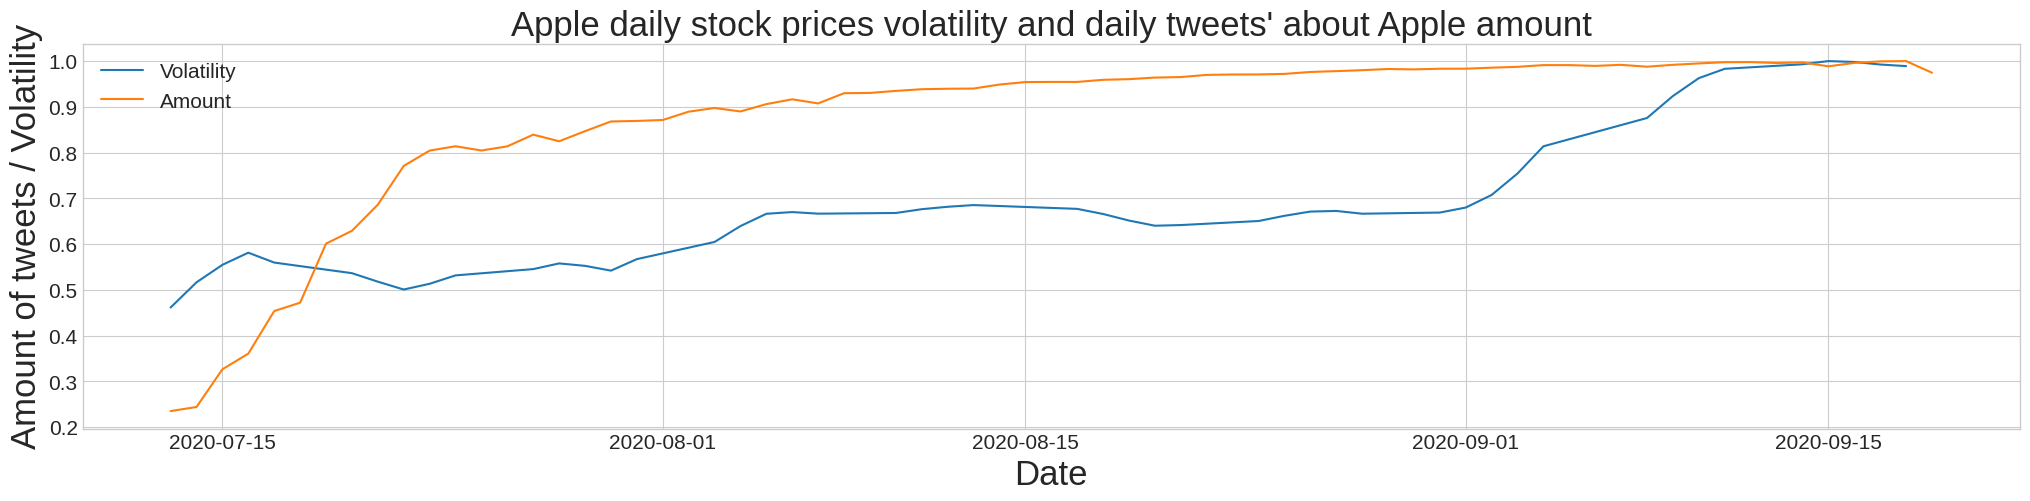

In [19]:
plt.figure(figsize=(25, 5))
prices = history['Close'].ewm(7.5).mean()
amounts = amounts / np.max(amounts)
plt.plot(dates[3:], atr, label = 'Volatility')
plt.plot(keys[5:], amounts[5:], label = 'Amount')
plt.title('Apple daily stock prices volatility and daily tweets\' about Apple amount', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Amount of tweets / Volatility', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('apple_twitter_volatility_amount.pdf')

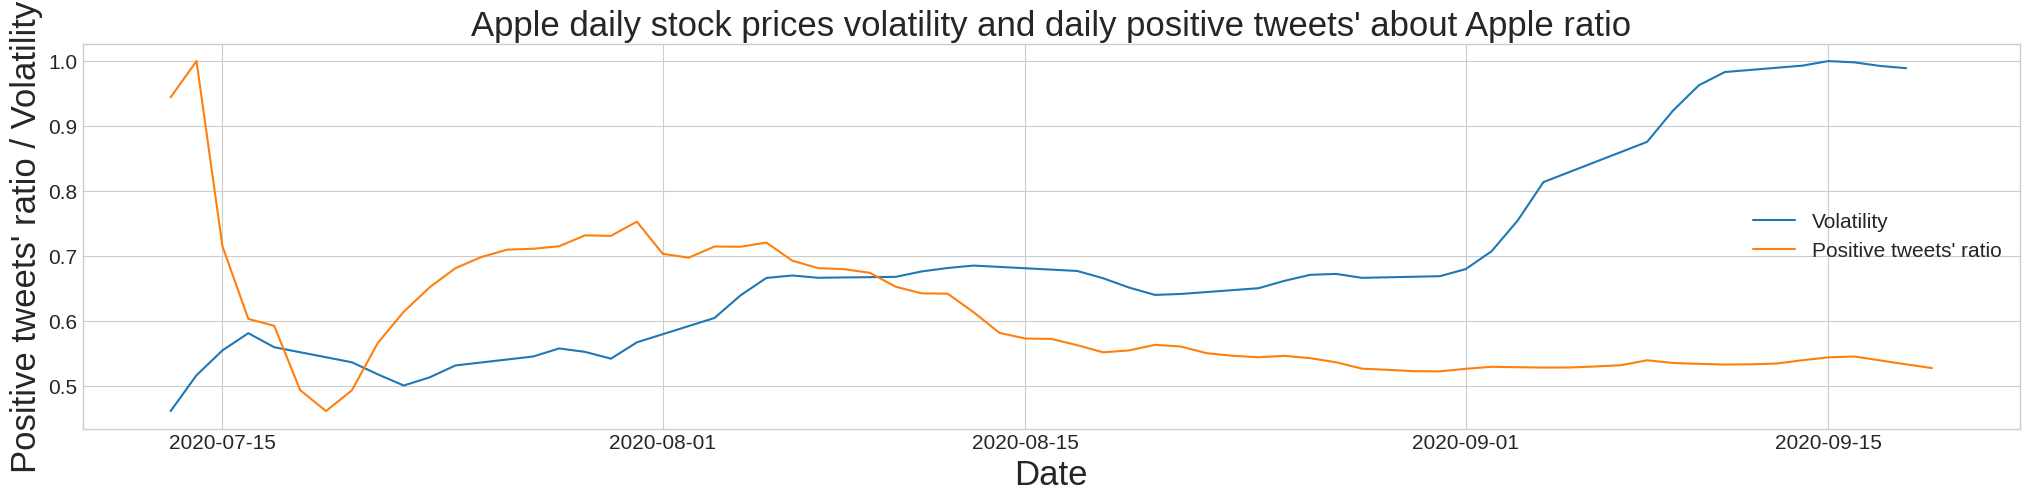

In [20]:
plt.figure(figsize=(25, 5))
normalized_sentiments = np.min(atr) + (heights[3:] - np.min(heights[3:])) / (np.max(heights[3:]) - np.min(heights[3:])) * (np.max(atr) - np.min(atr))
plt.plot(dates[3:], atr, label = 'Volatility')
plt.plot(keys[5:], normalized_sentiments[2:], label = 'Positive tweets\' ratio')
plt.title('Apple daily stock prices volatility and daily positive tweets\' about Apple ratio', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Positive tweets\' ratio / Volatility', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('apple_twitter_volatility_sentiments.pdf')

In [22]:
import scipy.stats as sp
def extraDataDeleting(heights):
  heights = list(heights)
  for date in keys:
    if date not in dates:
      heights[keys.index(date)] = 0
  for date in dates:
    if date not in keys:
      prices[dates.index(date)] = -1
  sentiments = []
  stock_prices = []
  for sentiment in heights:
    if sentiment != 0:
      sentiments.append(sentiment)
  for price in prices:
    if price != -1:
      stock_prices.append(price)
  return sentiments, stock_prices

In [23]:
sentiments, stock_prices = extraDataDeleting(heights)
amounts, stock_prices = extraDataDeleting(amounts)

In [24]:
from dtaidistance import dtw
import scipy.stats as sp

print('Pearson', sp.pearsonr(sentiments, stock_prices)[0])
print('Spearman', sp.spearmanr(sentiments, stock_prices)[0])
print('Kendalltau', sp.kendalltau(sentiments, stock_prices)[0])
stock_prices = stock_prices / np.max(stock_prices)
print('DTW', dtw.distance(sentiments, stock_prices))
print('Pearson (amount-volatility)', sp.pearsonr(amounts[5:], atr[2:])[0])
print('Spearman (amount-volatility)', sp.spearmanr(amounts[5:], atr[2:])[0])
print('Kendalltau (amount-volatility)', sp.kendalltau(amounts[5:], atr[2:])[0])
print('Pearson (sentiment-volatility)', sp.pearsonr(sentiments[5:], atr[2:])[0])
print('Spearman (sentiment-volatility)', sp.spearmanr(sentiments[5:], atr[2:])[0])
print('Kendalltau (sentiment-volatility)', sp.kendalltau(sentiments[5:], atr[2:])[0])

Pearson -0.675128018459485
Spearman -0.8633142661999488
Kendalltau -0.7194570135746607
DTW 0.6690874980455817
Pearson (amount-volatility) 0.543381021531681
Spearman (amount-volatility) 0.8848288621646625
Kendalltau (amount-volatility) 0.7132284921369103
Pearson (sentiment-volatility) -0.5305768289371506
Spearman (sentiment-volatility) -0.5778214616096208
Kendalltau (sentiment-volatility) -0.39500462534690106


<Figure size 2500x500 with 0 Axes>

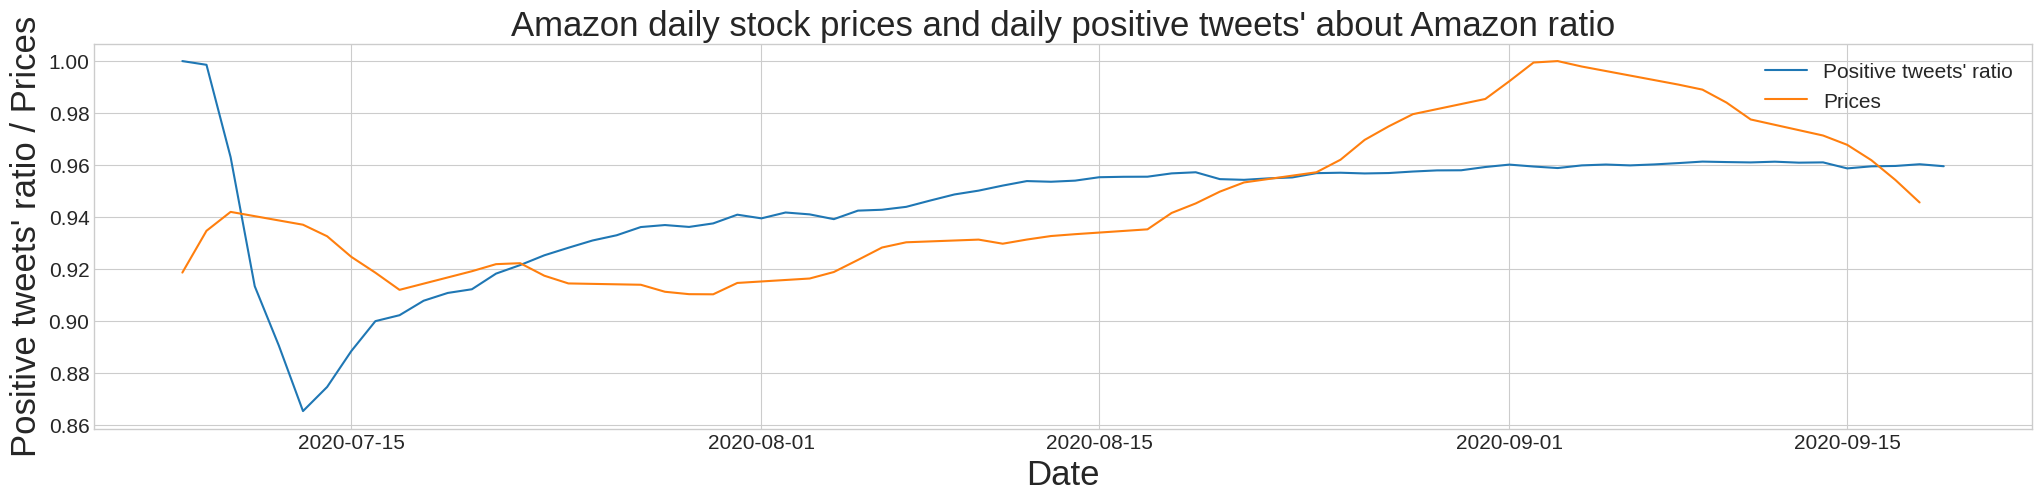

In [25]:
from matplotlib import style
from scipy.signal import savgol_filter
plt.figure(figsize=(25,5))

amazon_twitter = twitter_dataset[twitter_dataset.Ticker == 'Amazon']
grouped = amazon_twitter.groupby('Release date', group_keys=True, sort=True)
keys = list(grouped.groups.keys())[0:]
heights = grouped.agg({'Sentiment':[relation_count]})['Sentiment']['relation_count'].ewm(com=200.5).mean()
heights = np.array(heights)
amounts = grouped.agg({'Sentiment':['count']})['Sentiment']['count'].ewm(30).mean()
amounts = amounts / np.max(amounts)
amounts = np.array(amounts)

import yfinance as yahooFinance
plt.figure(figsize=(25, 5))
amazon_history = yahooFinance.Ticker("AMZN")
plt.title('Daily Apple mean historical stock prices')
plt.xlabel('Date')
plt.ylabel('Historical stock prices')
history = amazon_history.history(start="2020-07-08", end='2020-09-19')
history.reset_index(inplace=True)
history['Date']  = pd.to_datetime(history['Date']).dt.date
prices = history['Close'].ewm(7.5).mean()
prices = prices / np.max(prices)
heights = heights / np.max(heights)
dates = list(history['Date'])
plt.plot(keys, heights, label = 'Positive tweets\' ratio')
plt.plot(dates, prices, label = 'Prices')
plt.title('Amazon daily stock prices and daily positive tweets\' about Amazon ratio', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Positive tweets\' ratio / Prices', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('twitter_amazon_prices_sentiments.pdf')

In [26]:
high_low = history['High'] - history['Low']
high_close = np.abs(history['High'] - history['Close'].shift())
low_close = np.abs(history['Low'] - history['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
atr = pd.DataFrame(true_range.rolling(4).sum()/4)
atr = atr.ewm(30).mean()
atr = atr[3:]
atr = atr / np.max(atr)
atr = np.array(atr[0])

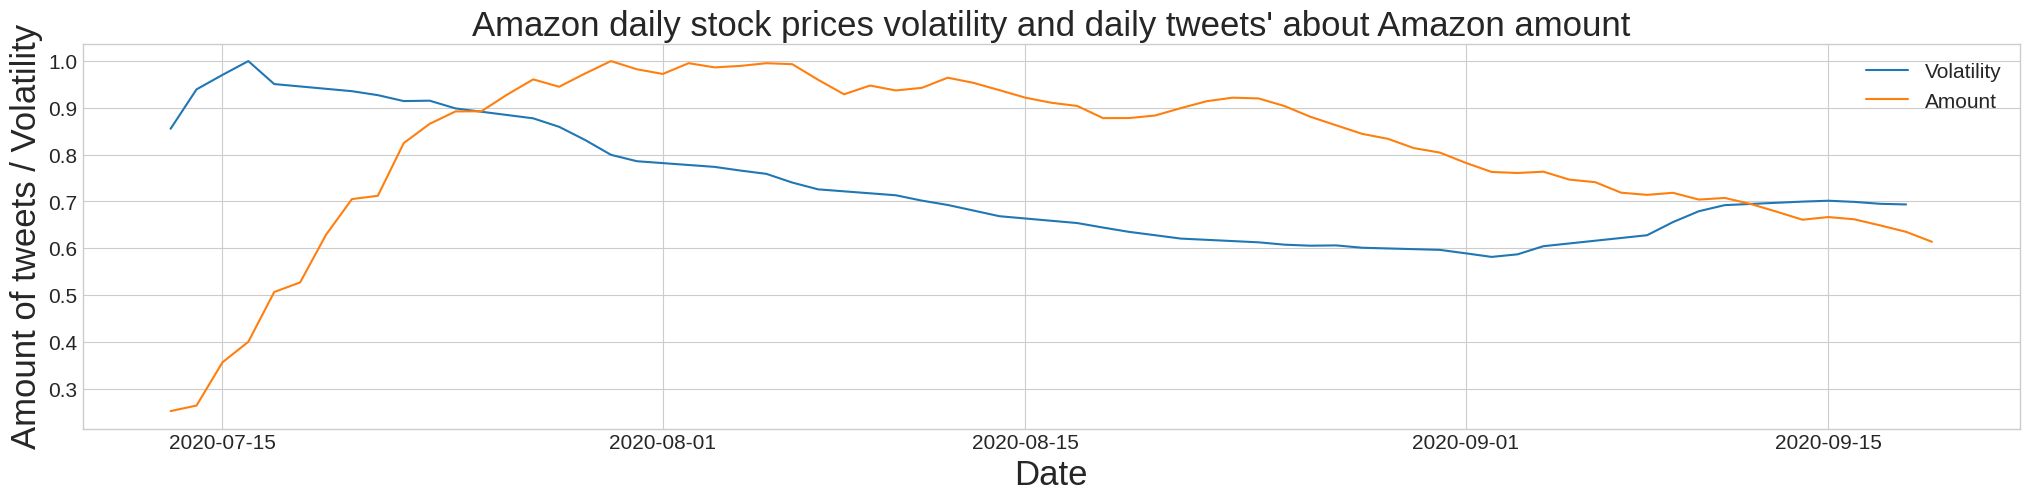

In [27]:
plt.figure(figsize=(25, 5))
prices = history['Close'].ewm(7.5).mean()
amounts = amounts / np.max(amounts)
plt.plot(dates[3:], atr, label = 'Volatility')
plt.plot(keys[5:], amounts[5:], label = 'Amount')
plt.title('Amazon daily stock prices volatility and daily tweets\' about Amazon amount', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Amount of tweets / Volatility', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('amazon_twitter_volatility_amount.pdf')

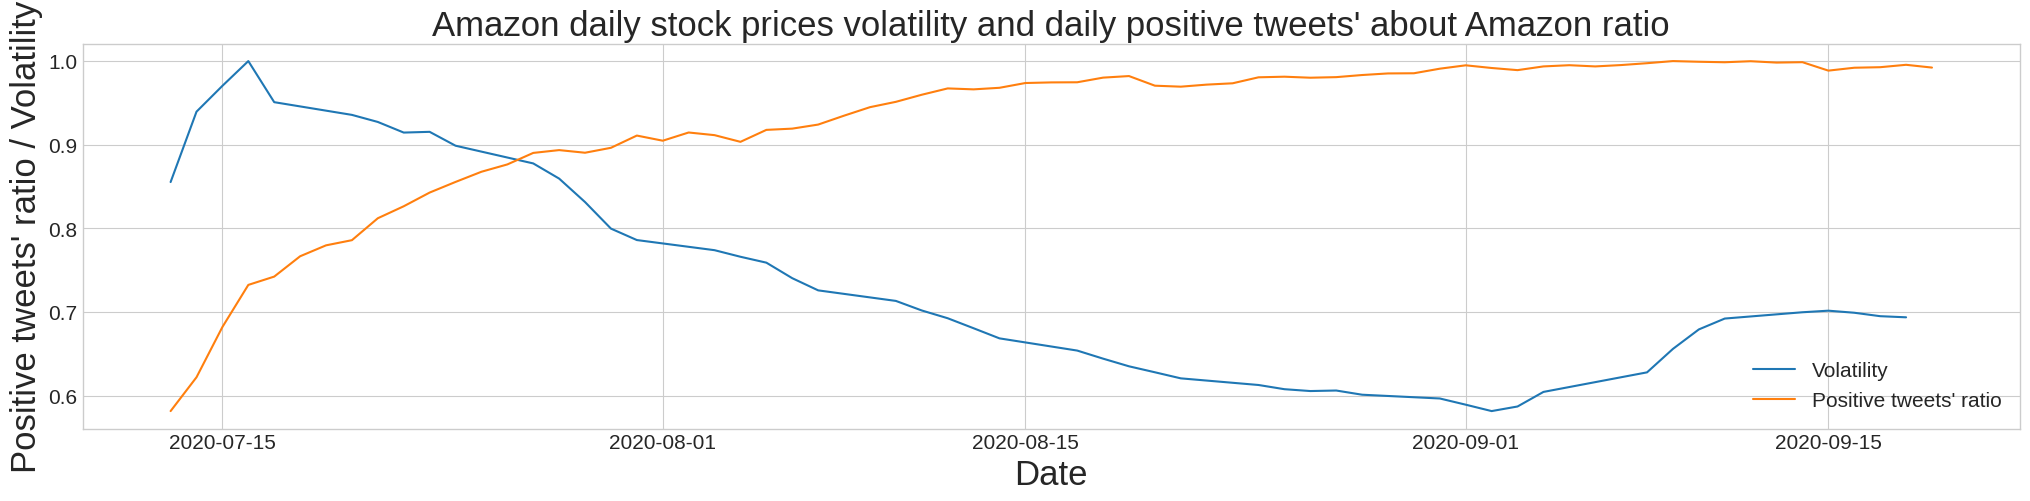

In [28]:
plt.figure(figsize=(25, 5))
normalized_sentiments = np.min(atr) + (heights[3:] - np.min(heights[3:])) / (np.max(heights[3:]) - np.min(heights[3:])) * (np.max(atr) - np.min(atr))
plt.plot(dates[3:], atr, label = 'Volatility')
plt.plot(keys[5:], normalized_sentiments[2:], label = 'Positive tweets\' ratio')
plt.title('Amazon daily stock prices volatility and daily positive tweets\' about Amazon ratio', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Positive tweets\' ratio / Volatility', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('amazon_twitter_volatility_sentiments.pdf')

In [29]:
sentiments, stock_prices = extraDataDeleting(heights)
amounts, stock_prices = extraDataDeleting(amounts)

In [30]:
from dtaidistance import dtw
import scipy.stats as sp

print('Pearson', sp.pearsonr(sentiments, stock_prices)[0])
print('Spearman', sp.spearmanr(sentiments, stock_prices)[0])
print('Kendalltau', sp.kendalltau(sentiments, stock_prices)[0])
stock_prices = stock_prices / np.max(stock_prices)
print('DTW', dtw.distance(sentiments, stock_prices))
print('Pearson (amount-volatility)', sp.pearsonr(amounts[5:], atr[2:])[0])
print('Spearman (amount-volatility)', sp.spearmanr(amounts[5:], atr[2:])[0])
print('Kendalltau (amount-volatility)', sp.kendalltau(amounts[5:], atr[2:])[0])
print('Pearson (sentiment-volatility)', sp.pearsonr(sentiments[5:], atr[2:])[0])
print('Spearman (sentiment-volatility)', sp.spearmanr(sentiments[5:], atr[2:])[0])
print('Kendalltau (sentiment-volatility)', sp.kendalltau(sentiments[5:], atr[2:])[0])

Pearson 0.4474384393401774
Spearman 0.7384103133270725
Kendalltau 0.5490196078431373
DTW 0.16915053191081755
Pearson (amount-volatility) -0.269655222109617
Spearman (amount-volatility) 0.056082331174838115
Kendalltau (amount-volatility) 0.05457909343200741
Pearson (sentiment-volatility) -0.9235877256630675
Spearman (sentiment-volatility) -0.7903561517113784
Kendalltau (sentiment-volatility) -0.6725254394079557


<Figure size 2500x500 with 0 Axes>

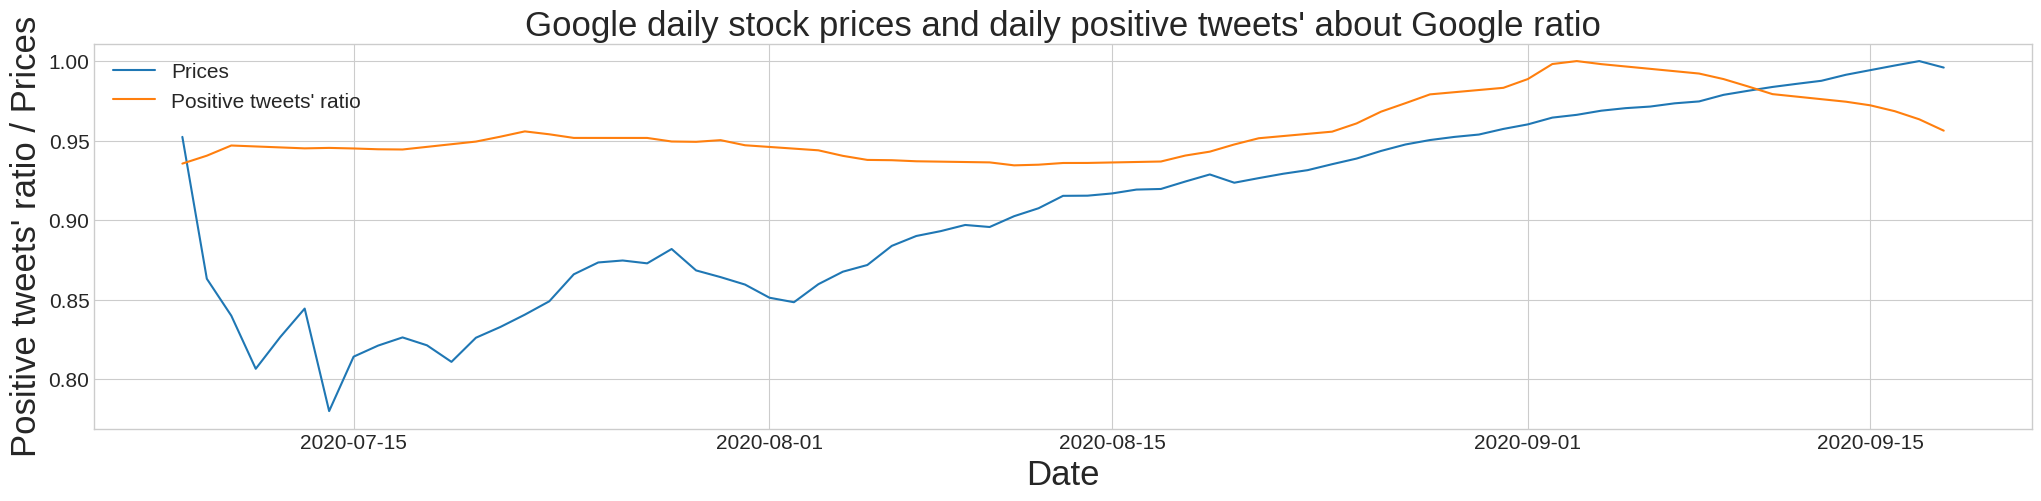

In [31]:
from matplotlib import style
from scipy.signal import savgol_filter
plt.figure(figsize=(25,5))

google_twitter = twitter_dataset[twitter_dataset.Ticker == 'Google']
grouped = google_twitter.groupby('Release date', group_keys=True, sort=True)
keys = list(grouped.groups.keys())[0:]
heights = grouped.agg({'Sentiment':[relation_count]})['Sentiment']['relation_count'].ewm(com=200.5).mean()
heights = np.array(heights)
amounts = grouped.agg({'Sentiment':['count']})['Sentiment']['count'].ewm(30).mean()
amounts = amounts / np.max(amounts)
amounts = np.array(amounts)

import yfinance as yahooFinance
plt.figure(figsize=(25, 5))
google_history = yahooFinance.Ticker("GOOGL")
plt.title('Daily Apple mean historical stock prices')
plt.xlabel('Date')
plt.ylabel('Historical stock prices')
history = google_history.history(start="2020-07-08", end='2020-09-19')
history.reset_index(inplace=True)
history['Date']  = pd.to_datetime(history['Date']).dt.date
prices = history['Close'].ewm(7.5).mean()
prices = prices / np.max(prices)
heights = heights / np.max(heights)
dates = list(history['Date'])
plt.plot(keys, heights, label = 'Prices')
plt.plot(dates, prices, label = 'Positive tweets\' ratio')
plt.title('Google daily stock prices and daily positive tweets\' about Google ratio', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Positive tweets\' ratio / Prices', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('google_twitter_sentiments_prices.pdf')

In [32]:
high_low = history['High'] - history['Low']
high_close = np.abs(history['High'] - history['Close'].shift())
low_close = np.abs(history['Low'] - history['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
atr = pd.DataFrame(true_range.rolling(4).sum()/4)
atr = atr.ewm(30).mean()
atr = atr[3:]
atr = atr / np.max(atr)
atr = np.array(atr[0])

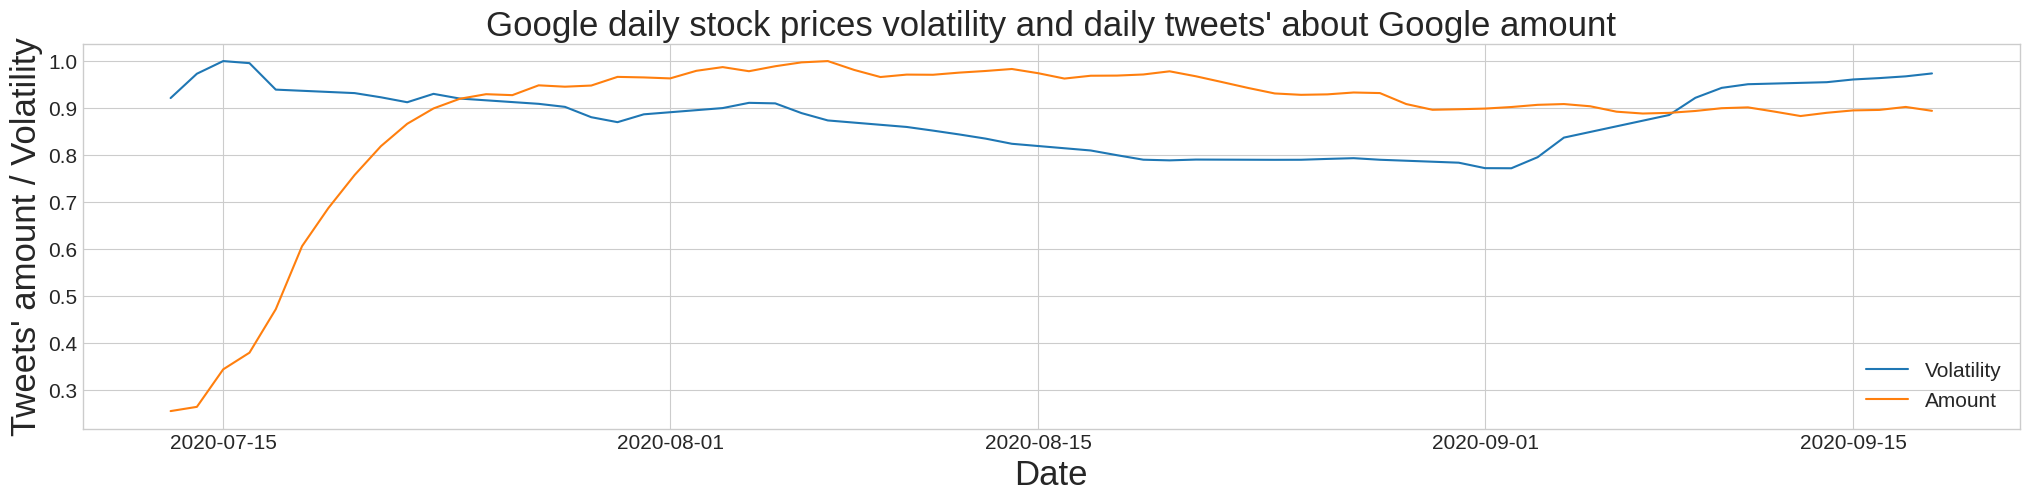

In [33]:
plt.figure(figsize=(25, 5))
prices = history['Close'].ewm(7.5).mean()
amounts = amounts / np.max(amounts)
plt.plot(dates[3:], atr, label = 'Volatility')
plt.plot(keys[5:], amounts[5:], label = 'Amount')
plt.title('Google daily stock prices volatility and daily tweets\' about Google amount', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Tweets\' amount / Volatility', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('google_twitter_volatility_amount.pdf')

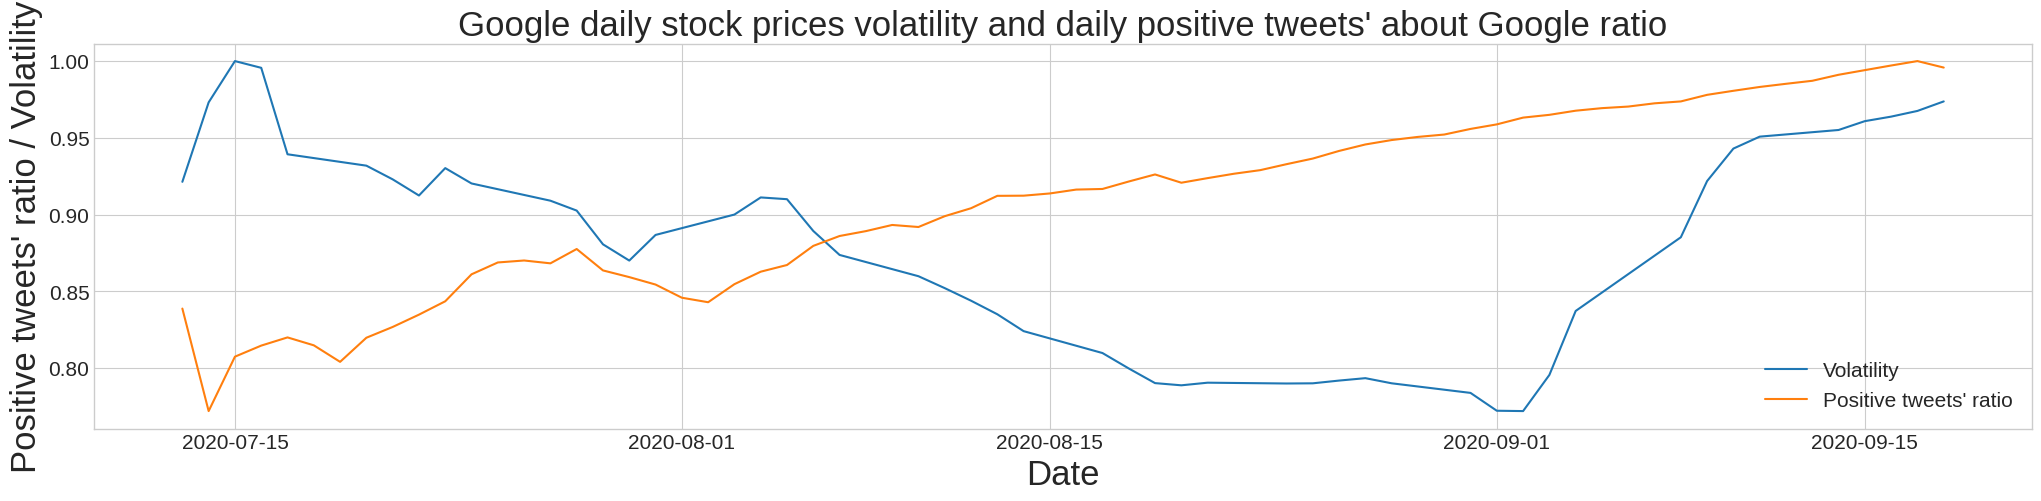

In [34]:
plt.figure(figsize=(25, 5))
normalized_sentiments = np.min(atr) + (heights[3:] - np.min(heights[3:])) / (np.max(heights[3:]) - np.min(heights[3:])) * (np.max(atr) - np.min(atr))
plt.plot(dates[3:], atr, label = 'Volatility')
plt.plot(keys[5:], normalized_sentiments[2:], label = 'Positive tweets\' ratio')
plt.title('Google daily stock prices volatility and daily positive tweets\' about Google ratio', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Positive tweets\' ratio / Volatility', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('google_twitter_volatility_sentiments.pdf')

In [35]:
sentiments, stock_prices = extraDataDeleting(heights)
amounts, stock_prices = extraDataDeleting(amounts)

In [36]:
from dtaidistance import dtw
import scipy.stats as sp

print('Pearson', sp.pearsonr(sentiments, stock_prices)[0])
print('Spearman', sp.spearmanr(sentiments, stock_prices)[0])
print('Kendalltau', sp.kendalltau(sentiments, stock_prices)[0])
stock_prices = stock_prices / np.max(stock_prices)
print('DTW', dtw.distance(sentiments, stock_prices))
print('Pearson (amount-volatility)', sp.pearsonr(amounts[5:], atr[2:])[0])
print('Spearman (amount-volatility)', sp.spearmanr(amounts[5:], atr[2:])[0])
print('Kendalltau (amount-volatility)', sp.kendalltau(amounts[5:], atr[2:])[0])
print('Pearson (sentiment-volatility)', sp.pearsonr(sentiments[5:], atr[2:])[0])
print('Spearman (sentiment-volatility)', sp.spearmanr(sentiments[5:], atr[2:])[0])
print('Kendalltau (sentiment-volatility)', sp.kendalltau(sentiments[5:], atr[2:])[0])

Pearson 0.6286756402498106
Spearman 0.555792708955861
Kendalltau 0.32277526395173456
DTW 0.4236462251738383
Pearson (amount-volatility) -0.4890033496882565
Spearman (amount-volatility) -0.4697039777983349
Kendalltau (amount-volatility) -0.2876965772432933
Pearson (sentiment-volatility) -0.233766949014436
Spearman (sentiment-volatility) -0.15888066604995374
Kendalltau (sentiment-volatility) -0.23034227567067533


<Figure size 2500x500 with 0 Axes>

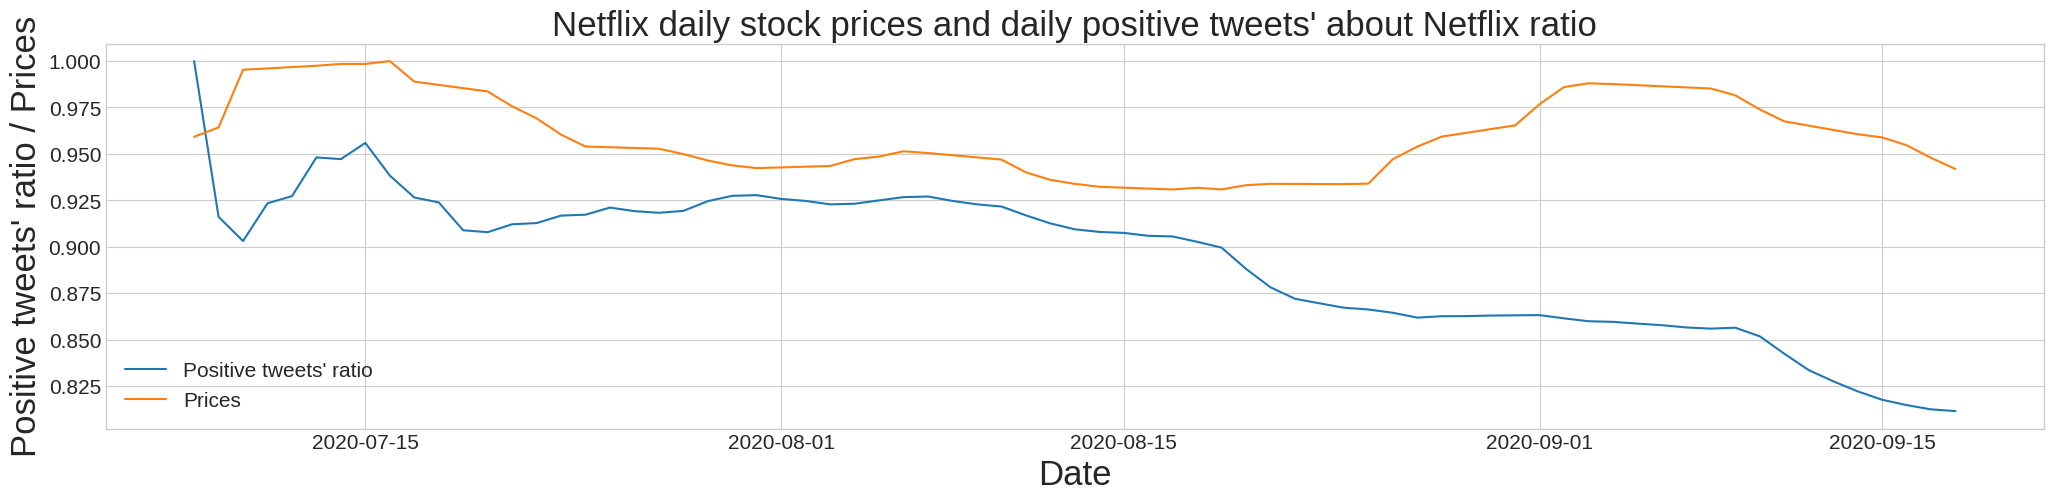

In [39]:
from matplotlib import style
from scipy.signal import savgol_filter
plt.figure(figsize=(25,5))

netflix_twitter = twitter_dataset[twitter_dataset.Ticker == 'Netflix']
grouped = netflix_twitter.groupby('Release date', group_keys=True, sort=True)
keys = list(grouped.groups.keys())[0:]
heights = grouped.agg({'Sentiment':[relation_count]})['Sentiment']['relation_count'].ewm(200.5).mean()
heights = np.array(heights)
amounts = grouped.agg({'Sentiment':['count']})['Sentiment']['count'].ewm(30).mean()
amounts = amounts / np.max(amounts)
amounts = np.array(amounts)


import yfinance as yahooFinance
plt.figure(figsize=(25, 5))
netflix_history = yahooFinance.Ticker("NFLX")
plt.title('Daily Apple mean historical stock prices')
plt.xlabel('Date')
plt.ylabel('Historical stock prices')
history = netflix_history.history(start="2020-07-08", end='2020-09-19')
history.reset_index(inplace=True)
history['Date']  = pd.to_datetime(history['Date']).dt.date
prices = history['Close'].ewm(7.5).mean()
prices = prices / np.max(prices)
heights = heights / np.max(heights)
dates = list(history['Date'])
plt.plot(keys, heights, label = 'Positive tweets\' ratio')
plt.plot(dates, prices, label = 'Prices')
plt.title('Netflix daily stock prices and daily positive tweets\' about Netflix ratio', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Positive tweets\' ratio / Prices', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('netflix_twitter_sentiments_prices.pdf')

In [40]:
high_low = history['High'] - history['Low']
high_close = np.abs(history['High'] - history['Close'].shift())
low_close = np.abs(history['Low'] - history['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
atr = pd.DataFrame(true_range.rolling(4).sum()/4)
atr = atr.ewm(30).mean()
atr = atr[3:]
atr = atr / np.max(atr)
atr = np.array(atr[0])

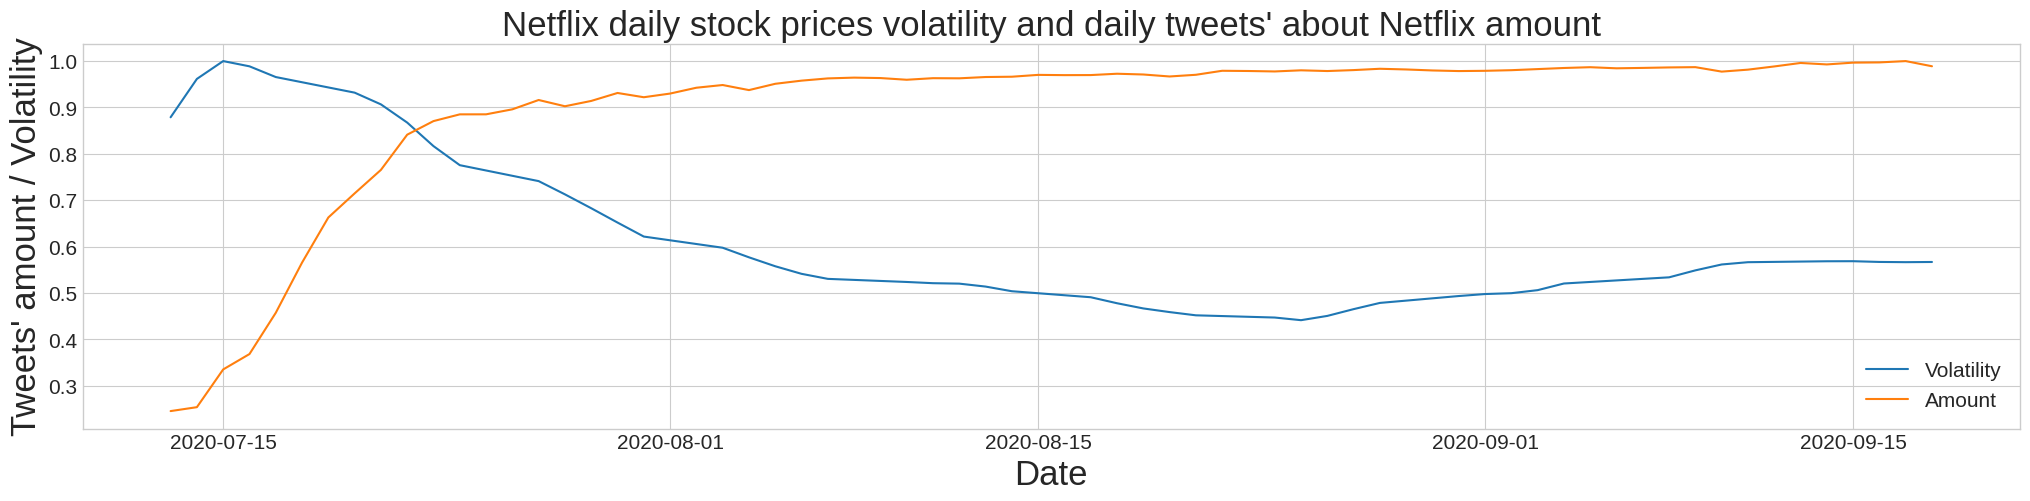

In [41]:
plt.figure(figsize=(25, 5))
prices = history['Close'].ewm(7.5).mean()
amounts = amounts / np.max(amounts)
plt.plot(dates[3:], atr, label = 'Volatility')
plt.plot(keys[5:], amounts[5:], label = 'Amount')
plt.title('Netflix daily stock prices volatility and daily tweets\' about Netflix amount', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Tweets\' amount / Volatility', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('netflix_twitter_volatility_amount.pdf')

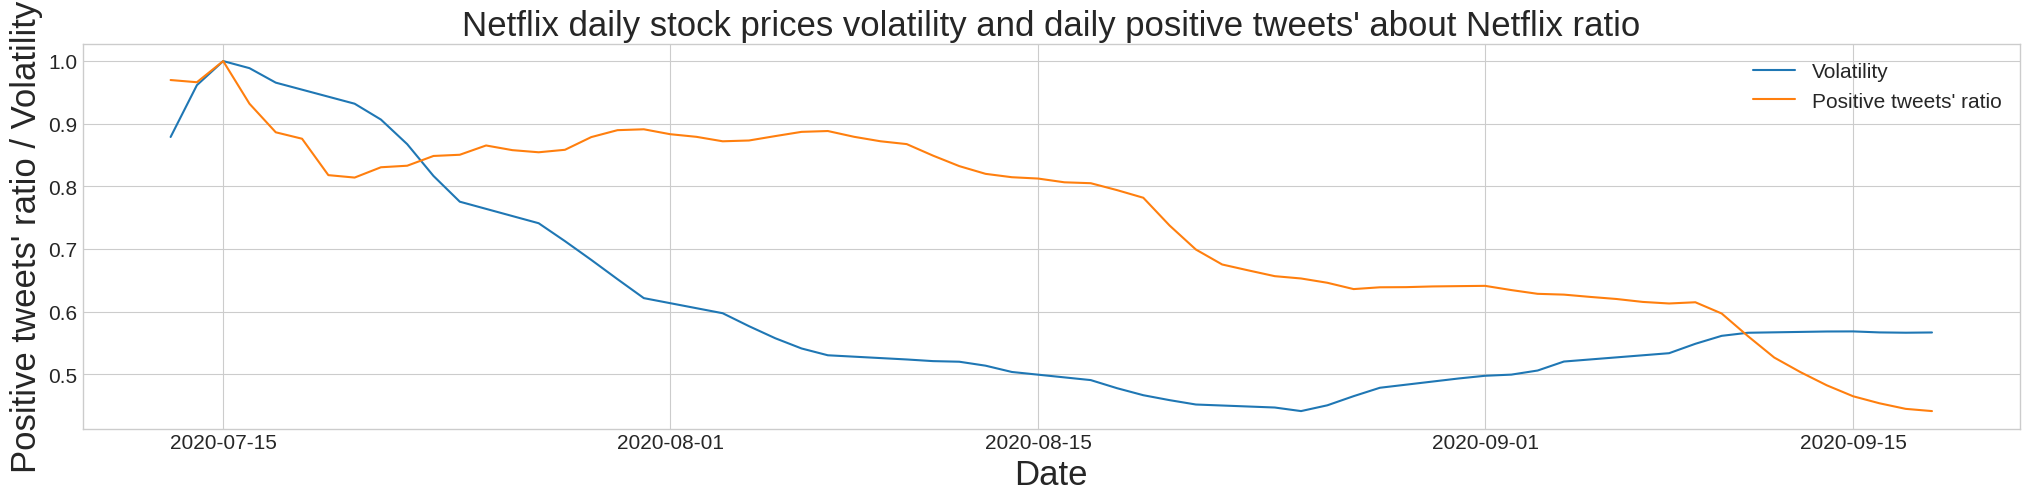

In [42]:
plt.figure(figsize=(25, 5))
normalized_sentiments = np.min(atr) + (heights[3:] - np.min(heights[3:])) / (np.max(heights[3:]) - np.min(heights[3:])) * (np.max(atr) - np.min(atr))
plt.plot(dates[3:], atr, label = 'Volatility')
plt.plot(keys[5:], normalized_sentiments[2:], label = 'Positive tweets\' ratio')
plt.title('Netflix daily stock prices volatility and daily positive tweets\' about Netflix ratio', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Positive tweets\' ratio / Volatility', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('netflix_twitter_volatility_sentiments.pdf')

In [43]:
sentiments, stock_prices = extraDataDeleting(heights)
amounts, stock_prices = extraDataDeleting(amounts)

In [44]:
from dtaidistance import dtw
import scipy.stats as sp

print('Pearson', sp.pearsonr(sentiments, stock_prices)[0])
print('Spearman', sp.spearmanr(sentiments, stock_prices)[0])
print('Kendalltau', sp.kendalltau(sentiments, stock_prices)[0])
stock_prices = stock_prices / np.max(stock_prices)
print('DTW', dtw.distance(sentiments, stock_prices))
print('Pearson (amount-volatility)', sp.pearsonr(amounts[5:], atr[2:])[0])
print('Spearman (amount-volatility)', sp.spearmanr(amounts[5:], atr[2:])[0])
print('Kendalltau (amount-volatility)', sp.kendalltau(amounts[5:], atr[2:])[0])
print('Pearson (sentiment-volatility)', sp.pearsonr(sentiments[5:], atr[2:])[0])
print('Spearman (sentiment-volatility)', sp.spearmanr(sentiments[5:], atr[2:])[0])
print('Kendalltau (sentiment-volatility)', sp.kendalltau(sentiments[5:], atr[2:])[0])

Pearson 0.06610225595478253
Spearman 0.02236830871681038
Kendalltau 0.015082956259426848
DTW 0.46391724254430855
Pearson (amount-volatility) -0.8509951435584711
Spearman (amount-volatility) -0.5837187789084182
Kendalltau (amount-volatility) -0.450508788159112
Pearson (sentiment-volatility) 0.4794563786836153
Spearman (sentiment-volatility) 0.4203283996299723
Kendalltau (sentiment-volatility) 0.23034227567067533


<Figure size 2500x500 with 0 Axes>

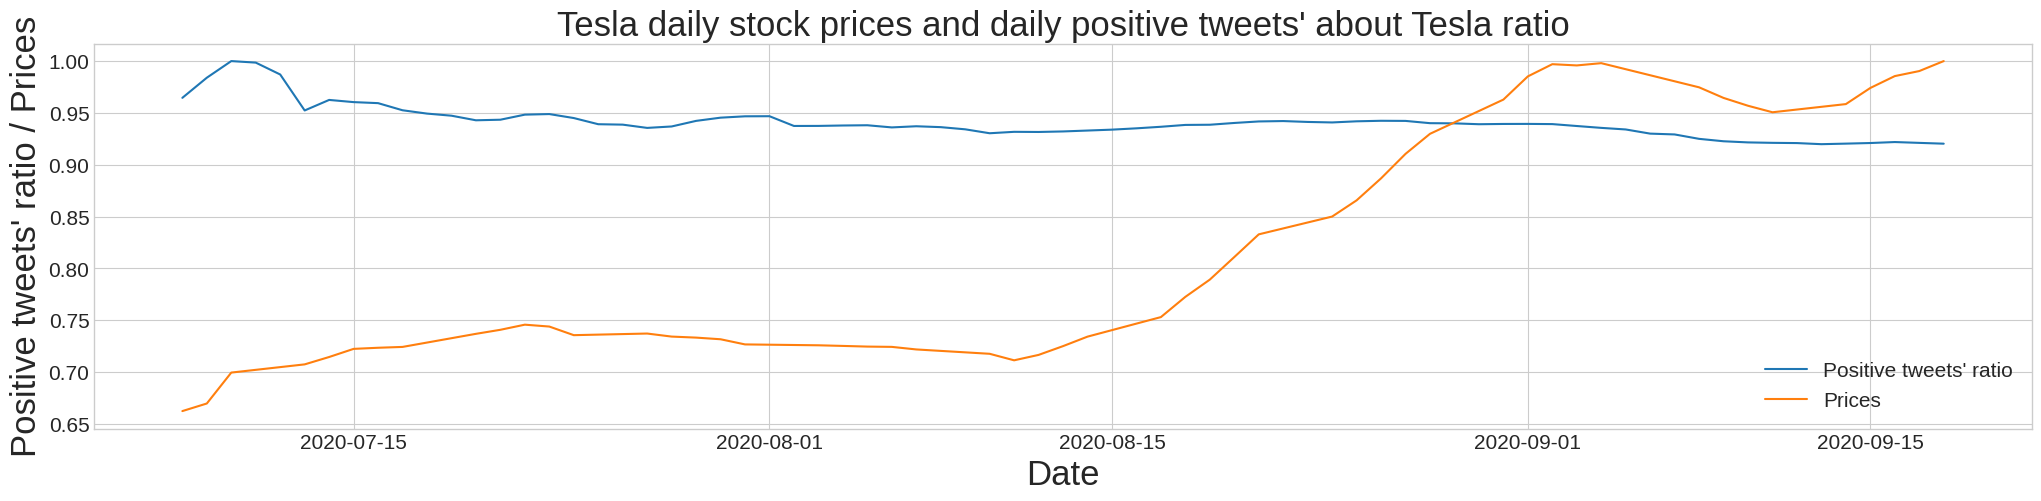

In [45]:
from matplotlib import style
from scipy.signal import savgol_filter
plt.figure(figsize=(25,5))

tesla_twitter = twitter_dataset[twitter_dataset.Ticker == 'Tesla']
grouped = tesla_twitter.groupby('Release date', group_keys=True, sort=True)
keys = list(grouped.groups.keys())[0:]
heights = grouped.agg({'Sentiment':[relation_count]})['Sentiment']['relation_count'].ewm(com=200.5).mean()
heights = np.array(heights)
amounts = grouped.agg({'Sentiment':['count']})['Sentiment']['count'].ewm(30).mean()
amounts = amounts / np.max(amounts)
amounts = np.array(amounts)

import yfinance as yahooFinance
plt.figure(figsize=(25, 5))
tesla_history = yahooFinance.Ticker("TSLA")
plt.title('Daily Apple mean historical stock prices')
plt.xlabel('Date')
plt.ylabel('Historical stock prices')
history = tesla_history.history(start="2020-07-08", end='2020-09-19')
history.reset_index(inplace=True)
history['Date']  = pd.to_datetime(history['Date']).dt.date
prices = history['Close'].ewm(7.5).mean()
prices = prices / np.max(prices)
heights = heights / np.max(heights)
dates = list(history['Date'])
plt.plot(keys, heights, label = 'Positive tweets\' ratio')
plt.plot(dates, prices, label = 'Prices')
plt.title('Tesla daily stock prices and daily positive tweets\' about Tesla ratio', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Positive tweets\' ratio / Prices', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('tesla_twitter_sentiments_prices.pdf')

In [46]:
high_low = history['High'] - history['Low']
high_close = np.abs(history['High'] - history['Close'].shift())
low_close = np.abs(history['Low'] - history['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
atr = pd.DataFrame(true_range.rolling(4).sum()/4)
atr = atr.ewm(30).mean()
atr = atr[3:]
atr = atr / np.max(atr)
atr = np.array(atr[0])

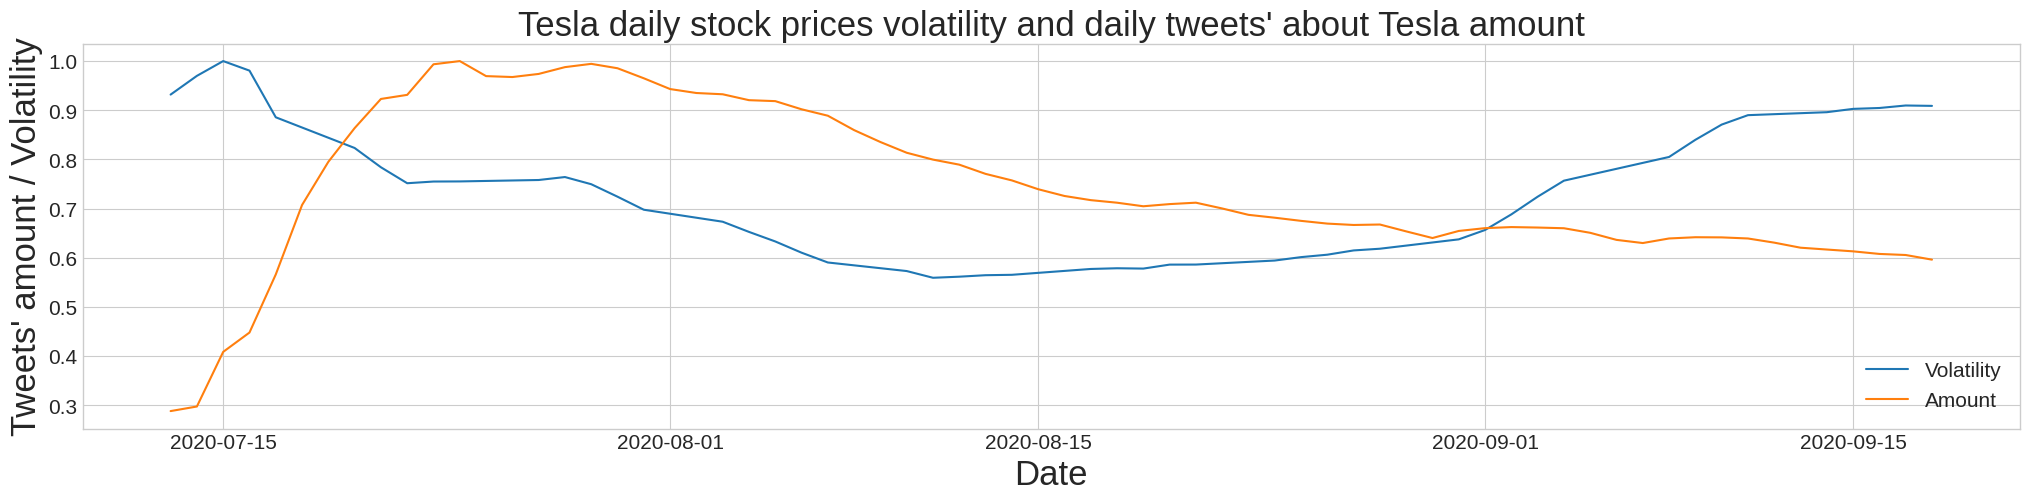

In [47]:
plt.figure(figsize=(25, 5))
prices = history['Close'].ewm(7.5).mean()
amounts = amounts / np.max(amounts)
plt.plot(dates[3:], atr, label = 'Volatility')
plt.plot(keys[5:], amounts[5:], label = 'Amount')
plt.title('Tesla daily stock prices volatility and daily tweets\' about Tesla amount', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Tweets\' amount / Volatility', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('tesla_twitter_volatility_amount.pdf')

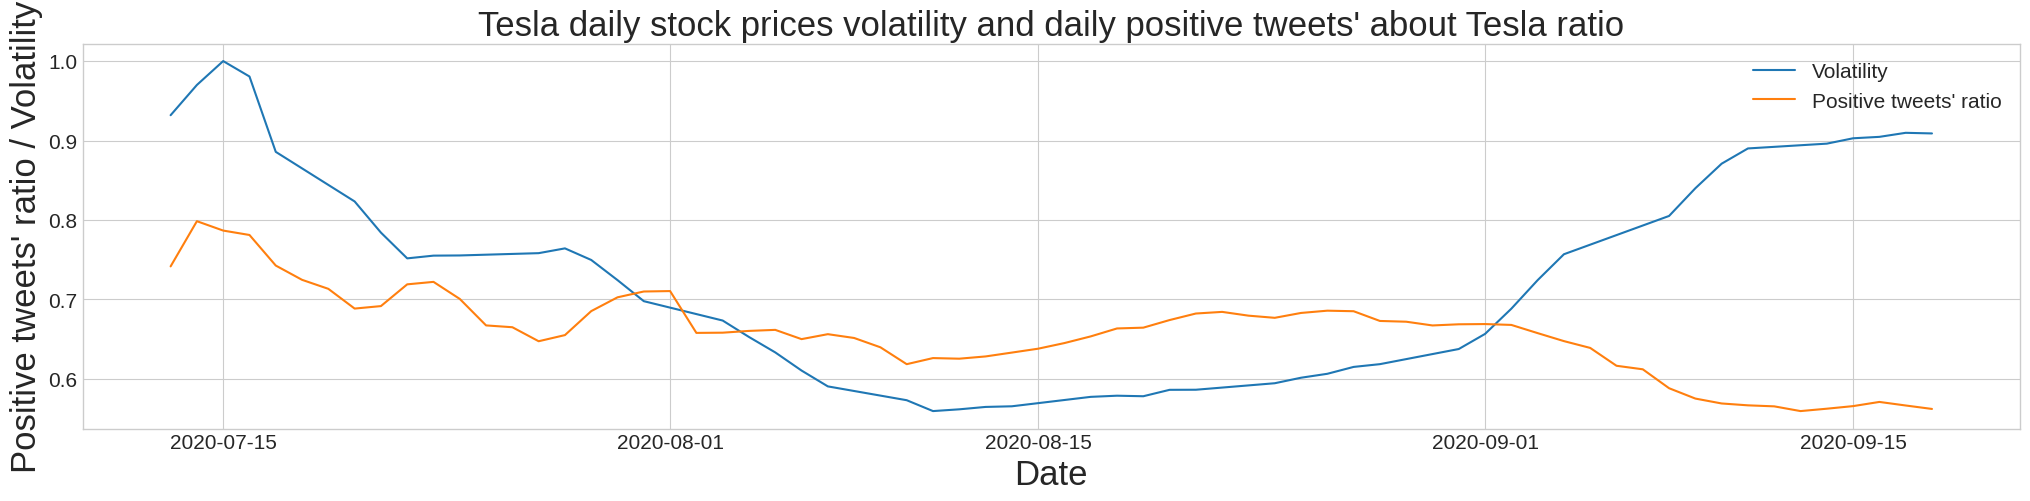

In [48]:
plt.figure(figsize=(25, 5))
normalized_sentiments = np.min(atr) + (heights[3:] - np.min(heights[3:])) / (np.max(heights[3:]) - np.min(heights[3:])) * (np.max(atr) - np.min(atr))
plt.plot(dates[3:], atr, label = 'Volatility')
plt.plot(keys[5:], normalized_sentiments[2:], label = 'Positive tweets\' ratio')
plt.title('Tesla daily stock prices volatility and daily positive tweets\' about Tesla ratio', fontsize = 25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Positive tweets\' ratio / Volatility', fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig('tesla_twitter_volatility_sentiments.pdf')

In [49]:
sentiments, stock_prices = extraDataDeleting(heights)
amounts, stock_prices = extraDataDeleting(amounts)

In [50]:
from dtaidistance import dtw
import scipy.stats as sp

print('Pearson', sp.pearsonr(sentiments, stock_prices)[0])
print('Spearman', sp.spearmanr(sentiments, stock_prices)[0])
print('Kendalltau', sp.kendalltau(sentiments, stock_prices)[0])
stock_prices = stock_prices / np.max(stock_prices)
print('DTW', dtw.distance(sentiments, stock_prices))
print('Pearson (amount-volatility)', sp.pearsonr(amounts[5:], atr[2:])[0])
print('Spearman (amount-volatility)', sp.spearmanr(amounts[5:], atr[2:])[0])
print('Kendalltau (amount-volatility)', sp.kendalltau(amounts[5:], atr[2:])[0])
print('Pearson (sentiment-volatility)', sp.pearsonr(sentiments[5:], atr[2:])[0])
print('Spearman (sentiment-volatility)', sp.spearmanr(sentiments[5:], atr[2:])[0])
print('Kendalltau (sentiment-volatility)', sp.kendalltau(sentiments[5:], atr[2:])[0])

Pearson -0.5690761415108893
Spearman -0.49816443268163574
Kendalltau -0.3559577677224736
DTW 1.2614797100049737
Pearson (amount-volatility) -0.3701767612301156
Spearman (amount-volatility) -0.42842275670675306
Kendalltau (amount-volatility) -0.333950046253469
Pearson (sentiment-volatility) -0.10520268779435712
Spearman (sentiment-volatility) -0.042437557816836266
Kendalltau (sentiment-volatility) 0.0009250693802035154
